## Cleaning NYPD Complaint data
In the following the <a href="https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data">NYPD Complaint data</a> from NYC Open Data will be cleaned and standardized

In [2]:
#Import the required packages
#Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np


The downloaded csv loaded in the next cell was filtered by for "Manhattan" so that only records related to Manhattan are present. No filtering for Manhattan within the notebook is therefore required.

In [3]:
# Read csv file
df = pd.read_csv('NYPD_Complaint_Data_Historic_20250529.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

C:\Users\lukej\AppData\Local\Temp\ipykernel_19676\251043343.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NYPD_Complaint_Data_Historic_20250529.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)


In [4]:
#How many rows should be displayed in full
pd.set_option('display.max_rows', 100)

In [5]:
# Show data frame first few rows
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,298702363,12/31/2024,21:40:00,12/31/2024,21:48:00,34.0,12/31/2024,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.863997,-73.924890,"(40.863997, -73.92489)",PATROL BORO MAN NORTH,(null),25-44,BLACK HISPANIC,M
1,298744735,12/31/2024,17:45:00,12/31/2024,17:50:00,34.0,12/31/2024,578,HARRASSMENT 2,638.0,...,U,NaN,40.860560,-73.925726,"(40.86056, -73.925726)",PATROL BORO MAN NORTH,(null),45-64,WHITE,M
2,298703736,12/31/2024,21:40:00,12/31/2024,21:48:00,34.0,12/31/2024,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.863997,-73.924890,"(40.863997, -73.92489)",PATROL BORO MAN NORTH,(null),25-44,BLACK HISPANIC,M
3,298686998,12/31/2024,04:00:00,12/31/2024,04:08:00,34.0,12/31/2024,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,F,NaN,40.865311,-73.919680,"(40.865311, -73.91968)",PATROL BORO MAN NORTH,(null),25-44,WHITE HISPANIC,F
4,298697870,12/01/2024,13:33:00,12/31/2024,08:30:00,30.0,12/31/2024,112,THEFT-FRAUD,739.0,...,(null),NaN,40.829688,-73.940649,"(40.829688, -73.940649)",PATROL BORO MAN NORTH,(null),65+,BLACK,M


In [6]:
# Keep only relevant columns for Brickwyze crime scoring
required_columns = ["CMPLNT_FR_DT", "OFNS_DESC", "LAW_CAT_CD", "Latitude", "Longitude"]

# Check if all required columns exist
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    # Use only available columns
    available_cols = [col for col in required_columns if col in df.columns]
    df_cleaned = df[available_cols]
else:
    df_cleaned = df[required_columns]

print(f"Selected {len(df_cleaned.columns)} columns: {list(df_cleaned.columns)}")


Selected 5 columns: ['CMPLNT_FR_DT', 'OFNS_DESC', 'LAW_CAT_CD', 'Latitude', 'Longitude']


In [7]:
# Remove rows with null coordinates
initial_count = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=["Latitude", "Longitude"])
removed_count = initial_count - len(df_cleaned)
print(f"Removed {removed_count:,} records with null coordinates")
print(f"Remaining records: {len(df_cleaned):,}")

Removed 73 records with null coordinates
Remaining records: 2,288,039


In [8]:
# Add crime severity weights

def assign_severity_weight(law_cat):
    """
    Assign numerical weight based on crime severity:
    FELONY = 3 points
    MISDEMEANOR = 2 points
    VIOLATION = 1 point
    """
    if pd.isna(law_cat):
        return 0
    law_cat = str(law_cat).upper()
    if law_cat == "FELONY":
        return 3
    elif law_cat == "MISDEMEANOR":
        return 2
    elif law_cat == "VIOLATION":
        return 1
    else:
        return 0

df_cleaned["severity_weight"] = df_cleaned["LAW_CAT_CD"].apply(assign_severity_weight)


In [9]:
# Rename columns
column_mapping = {
    "CMPLNT_FR_DT": "Date",
    "OFNS_DESC": "Crime_Type", 
    "LAW_CAT_CD": "Severity",
    "Latitude": "Latitude",
    "Longitude": "Longitude"
}

df_final = df_cleaned.rename(columns=column_mapping)


In [10]:
# Clean data types and remove invalid rows
# Convert date column to datetime
if "Date" in df_final.columns:
    df_final["Date"] = pd.to_datetime(df_final["Date"], errors='coerce')

# Drop any rows with missing critical values
df_final = df_final.dropna(subset=["Date", "Crime_Type", "Severity"])

# Sort by date (most recent first)
df_final = df_final.sort_values("Date", ascending=False)


In [11]:
# Remove obviously incorrect dates
print("Fixing date range...")
print(f"Before date filter: {len(df_final):,} records")
print(f"Date range: {df_final['Date'].min()} to {df_final['Date'].max()}")

# Remove dates before 2000 (data entry errors)
df_final = df_final[df_final['Date'] >= '2018-01-01']

print(f"After date filter: {len(df_final):,} records") 
print(f"New date range: {df_final['Date'].min()} to {df_final['Date'].max()}")

Fixing date range...
Before date filter: 2,287,851 records
Date range: 1900-05-08 00:00:00 to 2024-12-31 00:00:00
After date filter: 839,316 records
New date range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00


In [12]:
# Remove invalid coordinates (outside Manhattan bounds)
print("Cleaning coordinate data...")

# Manhattan approximate bounds: 
# Latitude: 40.70 to 40.88
# Longitude: -74.02 to -73.93
before_coord_clean = len(df_final)
df_final = df_final[
    (df_final["Latitude"] >= 40.70) & (df_final["Latitude"] <= 40.88) &
    (df_final["Longitude"] >= -74.02) & (df_final["Longitude"] <= -73.93)
]
coord_removed = before_coord_clean - len(df_final)
print(f"Removed {coord_removed:,} records with invalid Manhattan coordinates")
print(f"Remaining records: {len(df_final):,}")

Cleaning coordinate data...
Removed 28,932 records with invalid Manhattan coordinates
Remaining records: 810,384


In [13]:
# Remove duplicate incidents (same crime, same location, same date)
print("Removing duplicate incidents...")
before_dedup = len(df_final)
df_final = df_final.drop_duplicates(
    subset=["Date", "Crime_Type", "Severity", "Latitude", "Longitude"]
)
dedup_removed = before_dedup - len(df_final)
print(f"Removed {dedup_removed:,} duplicate records")
print(f"Cleaned records: {len(df_final):,}")

Removing duplicate incidents...
Removed 61,168 duplicate records
Cleaned records: 749,216


In [14]:
# Clean and standardize crime type descriptions
print("Standardizing crime types...")
df_final["Crime_Type"] = df_final["Crime_Type"].str.strip().str.upper()

# Show the effect
print("Sample of standardized crime types:")
print(df_final["Crime_Type"].value_counts().head(10))

Standardizing crime types...
Sample of standardized crime types:
Crime_Type
PETIT LARCENY                     175686
GRAND LARCENY                     106234
HARRASSMENT 2                      98388
ASSAULT 3 & RELATED OFFENSES       68553
CRIMINAL MISCHIEF & RELATED OF     60669
FELONY ASSAULT                     28167
OFF. AGNST PUB ORD SENSBLTY &      25367
BURGLARY                           23691
ROBBERY                            23047
DANGEROUS DRUGS                    22050
Name: count, dtype: int64


In [15]:
# Add time-based features for analysis
print("Adding time-based features...")

df_final["Year"] = df_final["Date"].dt.year
df_final["Month"] = df_final["Date"].dt.month
df_final["DayOfWeek"] = df_final["Date"].dt.dayofweek  # 0=Monday, 6=Sunday
df_final["Hour"] = df_final["Date"].dt.hour

print("Time features added: Year, Month, DayOfWeek, Hour")
print(f"Date range by year:")
print(df_final["Year"].value_counts().sort_index().tail())

Adding time-based features...
Time features added: Year, Month, DayOfWeek, Hour
Date range by year:
Year
2020     88533
2021     98967
2022    117216
2023    117117
2024    118498
Name: count, dtype: int64


In [16]:
# Final data quality summary
print("=== FINAL DATA QUALITY SUMMARY ===")
print(f"Total records: {len(df_final):,}")
print(f"Columns: {list(df_final.columns)}")
print(f"Date range: {df_final['Date'].min()} to {df_final['Date'].max()}")
print(f"Coordinate bounds:")
print(f"  Latitude: {df_final['Latitude'].min():.6f} to {df_final['Latitude'].max():.6f}")
print(f"  Longitude: {df_final['Longitude'].min():.6f} to {df_final['Longitude'].max():.6f}")
print(f"Missing values per column:")
print(df_final.isnull().sum())

=== FINAL DATA QUALITY SUMMARY ===
Total records: 749,216
Columns: ['Date', 'Crime_Type', 'Severity', 'Latitude', 'Longitude', 'severity_weight', 'Year', 'Month', 'DayOfWeek', 'Hour']
Date range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00
Coordinate bounds:
  Latitude: 40.701132 to 40.869042
  Longitude: -74.018156 to -73.930009
Missing values per column:
Date               0
Crime_Type         0
Severity           0
Latitude           0
Longitude          0
severity_weight    0
Year               0
Month              0
DayOfWeek          0
Hour               0
dtype: int64


In [17]:
# Save the clean csv file
df_final.to_csv("nypd_complaints_cleaned.csv", index=False)
print("Saved: nypd_complaints_cleaned.csv")

Saved: nypd_complaints_cleaned.csv


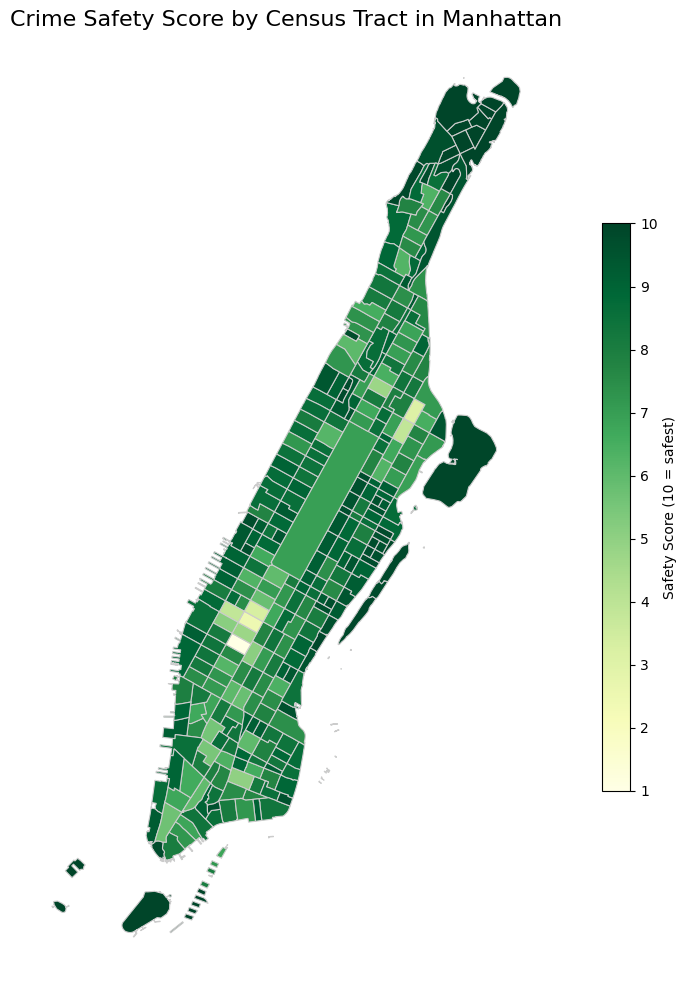

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the final crime scores
scores_df = pd.read_csv("crime_scores_by_tract.csv")

# Load the census tract geometries (must match GEOID field)
final_scores = gpd.read_file("../census tract geofiles/manhattan_census_tracts.geojson")

# Merge scores with geometries on GEOID
final_map = final_scores.merge(scores_df, on="GEOID", how="left")

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map with safety scores
final_map.plot(column="crime_score", 
               cmap="YlGn",             # Green = safer
               linewidth=0.8, 
               ax=ax, 
               edgecolor="0.8", 
               legend=True,
               legend_kwds={
                   "label": "Safety Score (10 = safest)", 
                   "shrink": 0.6
               })

# Add title and remove axes
ax.set_title("Crime Safety Score by Census Tract in Manhattan", fontsize=16)
ax.axis("off")

# Optional: Save the figure
# plt.savefig("manhattan_crime_safety_map.png", dpi=300)

# Show the map
plt.tight_layout()
plt.show()